<a href="https://colab.research.google.com/github/djmary-k/Py17DS_HW05/blob/main/Hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5
## Support Vector Machine (SVM), Decision Trees and Random Forests.
За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах. Даний датасет homework.zip.

Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features).

Порівняйте результати роботи обох алгоритмів на різних фічах та різні моделі між собою. Використайте метод classification report для порівняння.


In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Розарпаковка архіву. Переведення даних з файлів .csv у словник датасетів.

zip_file_path = '/content/drive/MyDrive/Colab Notebooks/homework.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

data_folder = 'data'

subdirectories = [subdir for subdir in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, subdir))]
print(subdirectories)
dataframes = {}

for subdir in subdirectories:
    subdir_path = os.path.join(data_folder, subdir)
    files = os.listdir(subdir_path)

    df = pd.DataFrame()

    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(subdir_path, file)
            data = pd.read_csv(file_path)
            df = pd.concat([df, data], ignore_index=True)

    dataframes[subdir] = df

for subdir, df in dataframes.items():
    print(f"Dataframe for {subdir}:")
    print(df.head())

['idle', 'running', 'walking', 'stairs']
Dataframe for idle:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0        -0.435745         5.837064         9.792285
1         0.239420         5.669470         8.020576
2         0.407014         5.276821         8.025364
3        -0.057461         5.506664         8.149863
4         0.679953         6.057330         8.264784
Dataframe for running:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0        -3.696647         4.419697        -1.814805
1        -1.541866       -11.042058        -8.231265
2        14.829685        33.154903         3.979163
3        -4.735731        14.302961         1.182736
4         6.287174       -13.311762        -4.137180
Dataframe for walking:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0        -1.182736        -8.441956        -1.450886
1        -6.086060       -12.473791        -3.610456
2        -3.754108        -0.076614        -3.308787
3        -5.137956       -13.843274        -2

In [ ]:
# Додавання до кожного датасету стовпця, що відповідає дії: 0 - 'idle', 1 - 'running', 2 - 'walking', 3 - 'stairs'.
# Обєднання всіх датасетів у один датафрейм
scaler = StandardScaler()


for index, (subdir, df) in enumerate(dataframes.items()):
    df['Action'] = index
    dataframes[subdir] = df

merged_df = pd.concat(dataframes.values(), ignore_index=True)
print(merged_df)

        accelerometer_X  accelerometer_Y  accelerometer_Z  Action
0             -0.435745         5.837064         9.792285       0
1              0.239420         5.669470         8.020576       0
2              0.407014         5.276821         8.025364       0
3             -0.057461         5.506664         8.149863       0
4              0.679953         6.057330         8.264784       0
...                 ...              ...              ...     ...
193855        -1.948880        -3.064578        -2.513912       3
193856         1.225831        -5.554548        -2.317587       3
193857         0.210690       -10.802638        -1.599327       3
193858         2.738967        -8.657434         4.031836       3
193859         4.094085       -11.401189        -0.651223       3

[193860 rows x 4 columns]


In [ ]:
# Нормалізація за допомогою StandardScaler
scaler = StandardScaler()

# Нормалізуємо дані, крім стовпця "Action"
normalized_data = merged_df.drop(columns=['Action'])
normalized_data = scaler.fit_transform(normalized_data)

# Створюємо DataFrame з нормалізованими даними
normalized_df = pd.DataFrame(normalized_data, columns=merged_df.columns[:-1])  # без стовпця "Action"

# Додаємо стовпець "Action" зі списку
normalized_df['Action'] = merged_df['Action']

print(normalized_df)

        accelerometer_X  accelerometer_Y  accelerometer_Z  Action
0             -0.280706         0.339804         1.110660       0
1             -0.200376         0.326369         0.864301       0
2             -0.180436         0.294891         0.864966       0
3             -0.235699         0.313317         0.882278       0
4             -0.147962         0.357462         0.898258       0
...                 ...              ...              ...     ...
193855        -0.460738        -0.373811        -0.600537       3
193856        -0.083014        -0.573424        -0.573238       3
193857        -0.203794        -0.994146        -0.473363       3
193858         0.097018        -0.822172         0.309660       3
193859         0.258248        -1.042129        -0.341527       3

[193860 rows x 4 columns]


In [ ]:
# Визначення списку індексів для початкових індексів кожного сегмента.
# Поділ даних на сегменти та розрахнок часових ознак для кожного сегмента.
# Створенння нового датафрейму, який містить часові ознаки для кожного сегмента разом з відповідними мітками класів.

# Крок переміщення між сегментами (50% перекриття)
segment_size = 208
step_size = int(segment_size / 2)

# Створення списку індексів для початкових індексів кожного сегмента
start_indexes = list(range(0, len(normalized_df), step_size))

In [ ]:
# Список для збереження часових ознак для кожного сегмента
time_domain_features = []

# Проходимося по кожному початковому індексу кожного сегмента
for start_index in start_indexes:
    # Визначаємо кінець поточного сегмента
    end_index = start_index + segment_size
    # Вибираємо дані для поточного сегмента
    segment_data = normalized_df.iloc[start_index:end_index, :-1]  # без стовпця "Action"

    # Розраховуємо часові ознаки для поточного сегмента
    segment_features = {
        'mean_x': segment_data['accelerometer_X'].mean(),
        'mean_y': segment_data['accelerometer_Y'].mean(),
        'mean_z': segment_data['accelerometer_Z'].mean(),
        'std_x': segment_data['accelerometer_X'].std(),
        'std_y': segment_data['accelerometer_Y'].std(),
        'std_z': segment_data['accelerometer_Z'].std(),
        'min_x': segment_data['accelerometer_X'].min(),
        'min_y': segment_data['accelerometer_Y'].min(),
        'min_z': segment_data['accelerometer_Z'].min(),
        'max_x': segment_data['accelerometer_X'].max(),
        'max_y': segment_data['accelerometer_Y'].max(),
        'max_z': segment_data['accelerometer_Z'].max(),
        'median_x': segment_data['accelerometer_X'].median(),
        'median_y': segment_data['accelerometer_Y'].median(),
        'median_z': segment_data['accelerometer_Z'].median(),
        '25th_percentile_x': segment_data['accelerometer_X'].quantile(0.25),
        '25th_percentile_y': segment_data['accelerometer_Y'].quantile(0.25),
        '25th_percentile_z': segment_data['accelerometer_Z'].quantile(0.25),
        '75th_percentile_x': segment_data['accelerometer_X'].quantile(0.75),
        '75th_percentile_y': segment_data['accelerometer_Y'].quantile(0.75),
        '75th_percentile_z': segment_data['accelerometer_Z'].quantile(0.75),
        'rms_x': np.sqrt(np.mean(segment_data['accelerometer_X'] ** 2)),
        'rms_y': np.sqrt(np.mean(segment_data['accelerometer_Y'] ** 2)),
        'rms_z': np.sqrt(np.mean(segment_data['accelerometer_Z'] ** 2)),
        'mean': np.mean([segment_data['accelerometer_X'].mean(),
                         segment_data['accelerometer_Y'].mean(),
                         segment_data['accelerometer_Z'].mean()]),
        'std': np.mean([segment_data['accelerometer_X'].std(),
                        segment_data['accelerometer_Y'].std(),
                        segment_data['accelerometer_Z'].std()]),
        'min': np.mean([segment_data['accelerometer_X'].min(),
                        segment_data['accelerometer_Y'].min(),
                        segment_data['accelerometer_Z'].min()]),
        'max': np.mean([segment_data['accelerometer_X'].max(),
                        segment_data['accelerometer_Y'].max(),
                        segment_data['accelerometer_Z'].max()]),
        'median': np.mean([segment_data['accelerometer_X'].median(),
                           segment_data['accelerometer_Y'].median(),
                           segment_data['accelerometer_Z'].median()]),
        '25th_percentile': np.mean([segment_data['accelerometer_X'].quantile(0.25),
                                    segment_data['accelerometer_Y'].quantile(0.25),
                                    segment_data['accelerometer_Z'].quantile(0.25)]),
        '75th_percentile': np.mean([segment_data['accelerometer_X'].quantile(0.75),
                                    segment_data['accelerometer_Y'].quantile(0.75),
                                    segment_data['accelerometer_Z'].quantile(0.75)]),
        'rms': np.mean([np.sqrt(np.mean(segment_data['accelerometer_X'] ** 2)),
                        np.sqrt(np.mean(segment_data['accelerometer_Y'] ** 2)),
                        np.sqrt(np.mean(segment_data['accelerometer_Z'] ** 2))])
    }

    # Додаємо часові ознаки до списку
    time_domain_features.append(segment_features)

# Створюємо DataFrame з часовими ознаками
time_domain_df = pd.DataFrame(time_domain_features)

# Додаємо стовпець "Action" зі списку індексів
time_domain_df['Action'] = normalized_df['Action'].iloc[::step_size].values

print(time_domain_df.head())


     mean_x    mean_y    mean_z     std_x     std_y     std_z     min_x  \
0 -0.221924  0.228689  0.859624  0.074071  0.231569  0.197380 -0.574112   
1 -0.219319  0.107648  0.929588  0.068048  0.270927  0.213425 -0.574112   
2 -0.225411  0.081166  0.977758  0.059370  0.242120  0.172047 -0.408893   
3 -0.212828 -0.008080  1.043567  0.105837  0.192321  0.117118 -0.900561   
4 -0.198215 -0.079294  1.079145  0.110948  0.133413  0.115175 -0.900561   

      min_y     min_z     max_x  ...     rms_z      mean       std       min  \
0 -0.270550  0.225099  0.063404  ...  0.881887  0.288796  0.167673 -0.206521   
1 -0.270550  0.395552  0.011560  ...  0.953659  0.272639  0.184134 -0.149703   
2 -0.138882  0.570667  0.011560  ...  0.992708  0.277838  0.157846  0.007631   
3 -0.333505  0.643909  0.739091  ...  1.050087  0.274220  0.138426 -0.196719   
4 -0.333505  0.091932  0.739091  ...  1.085244  0.267212  0.119845 -0.380711   

        max    median  25th_percentile  75th_percentile       rms  A

In [ ]:
time_domain_df.head(1)

,mean_x,mean_y,mean_z,std_x,std_y,std_z,min_x,min_y,min_z,max_x,...,rms_z,mean,std,min,max,median,25th_percentile,75th_percentile,rms,Action
0,-0.221924,0.228689,0.859624,0.074071,0.231569,0.19738,-0.574112,-0.27055,0.225099,0.063404,...,0.881887,0.288796,0.167673,-0.206521,0.566235,0.31417,0.111457,0.439653,0.480284,0


In [ ]:
# Розділення датасету на навчальний і тестовий.
from sklearn.model_selection import train_test_split

X = time_domain_df.drop(columns=['Action'])
y = time_domain_df['Action']
# Розділення даних у співвідношенні 80% для навчання та 20% для тестування
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Traine dataset size:', X_train.shape, y_train.shape)
print('Test dataset size:', X_test.shape, y_test.shape)



Traine dataset size: (1492, 32) (1492,)
Test dataset size: (373, 32) (373,)


In [ ]:
# Застосовуємо метод Support Vector Machine для тренування моделі
svc_linear_clf = SVC(kernel='linear', C=1.0, random_state=42)
svc_linear_clf.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
# Прогнозування та оцінка моделі
y_predict_svc = svc_linear_clf.predict(X_test)

print(f"accuracy score on training sample = {accuracy_score(svc_linear_clf.predict(X_train), y_train)}")
print(f"accuracy score on test sample = {accuracy_score(svc_linear_clf.predict(X_test), y_test)}\n")

print(classification_report(y_test, y_predict_svc))

accuracy score on training sample = 1.0
accuracy score on test sample = 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00       202
           2       1.00      1.00      1.00       103
           3       1.00      1.00      1.00        11

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373



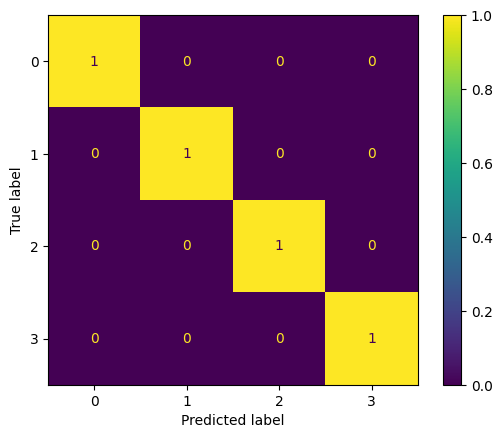

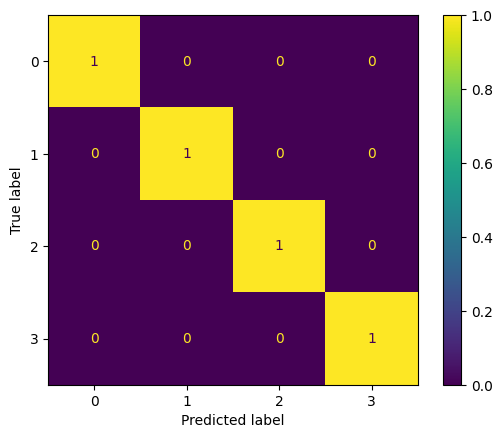

In [ ]:
# Візуалізуємо оцінку метода за допомогою Confusion Matrix
matrix_train=ConfusionMatrixDisplay.from_estimator(svc_linear_clf, X_train, y_train, normalize='true')
matrix_test=ConfusionMatrixDisplay.from_estimator(svc_linear_clf, X_test, y_test, normalize='true')

In [ ]:
# Застосовуємо метод SVM для тренування моделі з використанням Радіально базисної функції ядра (RBF)
svc_rbf_clf = SVC(kernel='rbf', random_state=42)
svc_rbf_clf.fit(X_train, y_train)

y_predict_svc_rbf = svc_rbf_clf.predict(X_test)

print(f"accuracy score on training sample = {accuracy_score(svc_rbf_clf.predict(X_train), y_train)}")
print(f"accuracy score on test sample = {accuracy_score(svc_rbf_clf.predict(X_test), y_test)}\n")

print(classification_report(y_test, y_predict_svc_rbf))

accuracy score on training sample = 0.9993297587131368
accuracy score on test sample = 0.9973190348525469

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        57
           1       1.00      1.00      1.00       202
           2       1.00      1.00      1.00       103
           3       1.00      1.00      1.00        11

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373



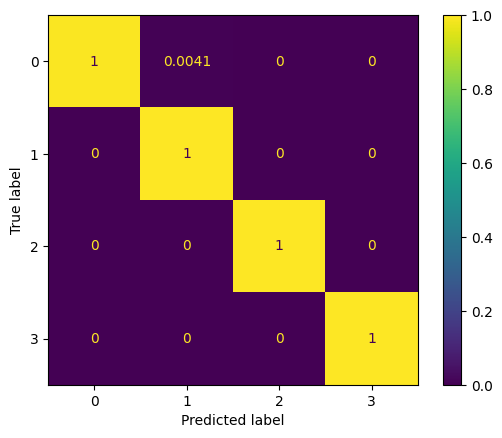

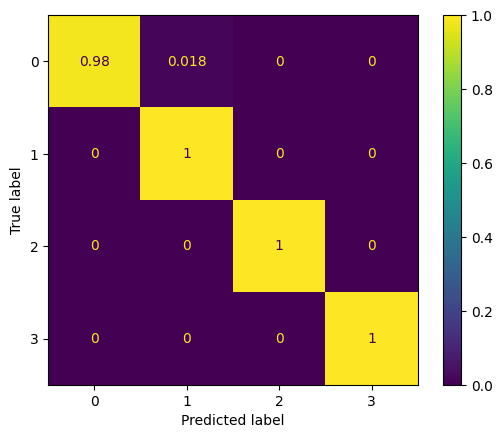

In [ ]:
# Візуалізуємо оцінку метода за допомогою Confusion Matrix
matrix_train=ConfusionMatrixDisplay.from_estimator(svc_rbf_clf, X_train, y_train, normalize='true')
matrix_test=ConfusionMatrixDisplay.from_estimator(svc_rbf_clf, X_test, y_test, normalize='true')

In [ ]:
# Робимо тренування, прогноз та оцінку за допомогою методу Дерева рішень RandomForestClassifier
rand_forrest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rand_forrest_clf.fit(X_train, y_train)

y_predict_rand_forest = rand_forrest_clf.predict(X_test)

print(f"accuracy score on training sample = {accuracy_score(rand_forrest_clf.predict(X_train), y_train)}")
print(f"accuracy score on test sample = {accuracy_score(rand_forrest_clf.predict(X_test), y_test)}\n")

print(classification_report(y_test, y_predict_rand_forest))

accuracy score on training sample = 1.0
accuracy score on test sample = 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00       202
           2       1.00      1.00      1.00       103
           3       1.00      1.00      1.00        11

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373



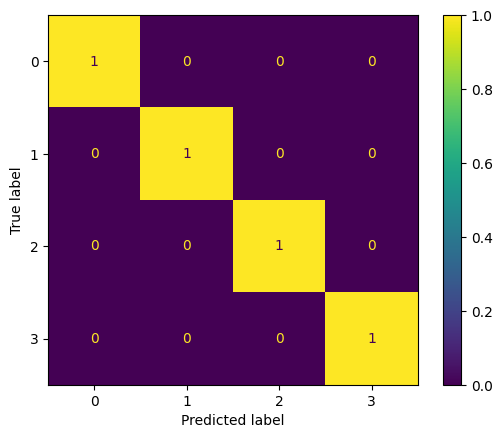

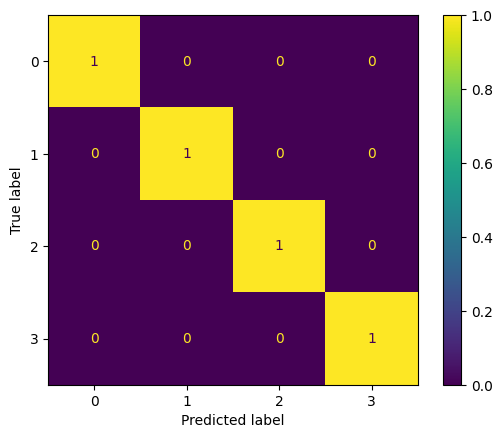

In [ ]:
# Візуалізуємо оцінку метода за допомогою Confusion Matrix
matrix_train=ConfusionMatrixDisplay.from_estimator(rand_forrest_clf, X_train, y_train, normalize='true')
matrix_test=ConfusionMatrixDisplay.from_estimator(rand_forrest_clf, X_test, y_test, normalize='true')

Отже, можна зробити такі висновки:
- Висока Загальна Точність: Усі моделі показали дуже високу загальну точність, що свідчить про їхню здатність ефективно класифікувати активності на основі даних акселерометра.
- Висока Точність по Класах: Моделі показали високі значення precision та recall для більшості класів, особливо для "idle", "running" та "walking".